In [1]:
from pathlib import Path 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np 
import json 
import plot_utils
from importlib import reload
reload(plot_utils)

plot_utils.set_style()
plt.ioff()

In [2]:
result_dir = Path('../results')
data_dir = Path('../data')

method_order = {'Ours': 0, 'pTS': 1, 'qEI': 2, 'Greedy': 3, 'UCB': 4}


# Maximizing homo-lumo gap 

### Loading, calculating

In [3]:
storage = []
for file in result_dir.glob('qm9*.json'): 
    with open(file, 'r') as f: 
        storage.extend(json.load(f))

Identify true top k and add to storage fraction of true top k information.

In [4]:
all_data = pd.read_csv(data_dir / 'qm9.csv')
all_smiles = list(all_data['smiles'])
test_data = {smi: score for smi, score in zip(all_smiles, all_data['gap'])}

k = [0.0001, 0.001, 0.01]
kN = [int(np.ceil(kk*len(test_data))) for kk in k]
for ki, kNi in zip(k, kN): print(f'{100*ki:0.2f}%: {kNi} compounds')
top_smis = {kk: set(sorted(list(test_data), key = lambda smi: -1*test_data[smi])[:kk]) for kk in kN}

for entry in storage: 
    for kkN, kk in zip(kN, k): 
        entry[f'Fraction top {100*kk:0.2f}%'] = len(top_smis[kkN].intersection(set(entry["All acquired points"].keys())))/kkN
    entry.pop("All acquired points")
    entry.pop("New acquired points")

data = pd.DataFrame(storage).sort_values(by='Method', key = lambda x: x.map(method_order))

0.01%: 14 compounds
0.10%: 134 compounds
1.00%: 1339 compounds


### Plotting

In [5]:
fig_dir = Path('qm9')
fig_dir.mkdir(exist_ok=True, parents=True)

latex = plot_utils.df_to_latex(data=data)
with open(fig_dir / 'table.txt', 'w') as f: 
    f.write(latex)

### Average of top k acquired 

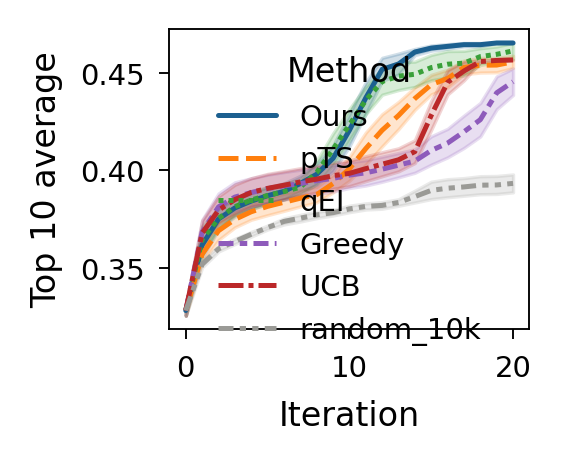

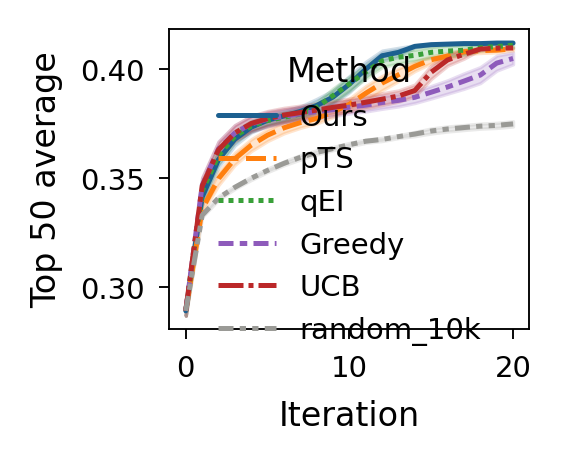

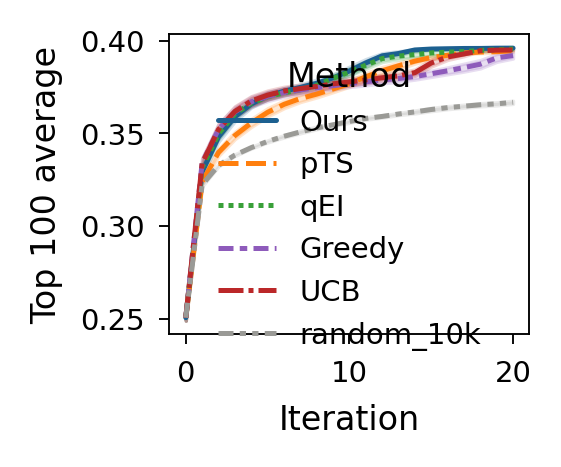

In [6]:
for kk in [10, 50, 100]:
    fig, ax = plt.subplots(1,1)
    sns.lineplot(
        data=data, x='Iteration', y=f'Top {kk} ave', 
        hue='Method', style='Method', palette=plot_utils.method_colors,
        ax=ax, errorbar=('se',1))
    ax.set_ylabel(f'Top {kk} average')
    plot_utils.set_size(w=1.2, h=1, ax=ax)
    fig.savefig(fig_dir / f'top_{kk}_average.pdf', bbox_inches='tight', transparent=True)



### Fraction of true top k 

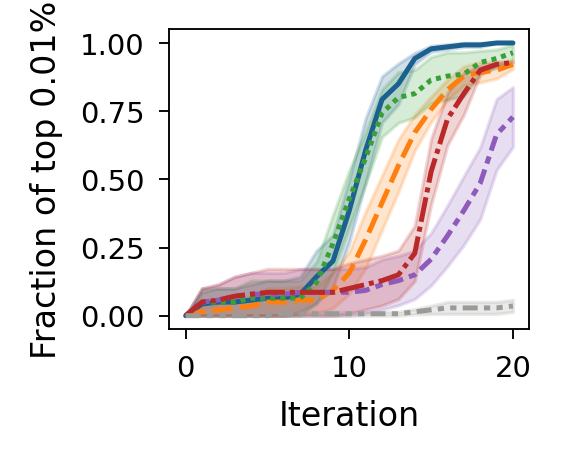

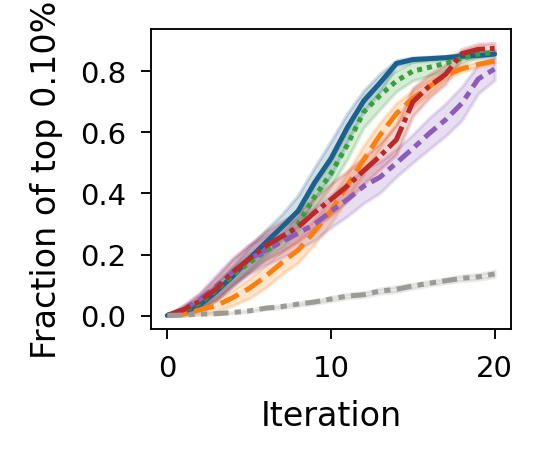

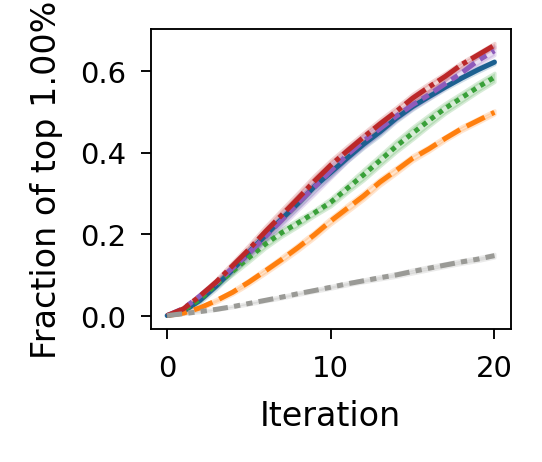

In [7]:
for kk, kkN in zip(k, kN):
    fig, ax = plt.subplots(1,1)
    sns.lineplot(
        data=data, x='Iteration', y=f'Fraction top {100*kk:0.2f}%', 
        hue='Method', style='Method', palette=plot_utils.method_colors,
        ax=ax, errorbar=("se", 1), legend=False)
    ax.set_ylabel(f'Fraction of top {100*kk:0.2f}%')
    plot_utils.set_size(w=1.2, h=1, ax=ax)
    fig.savefig(fig_dir / f'fraction_true_top_{kk}.pdf', bbox_inches='tight', transparent=True)


# Antibiotics

In [8]:
result_dir = Path('../results')

storage = []
for file in result_dir.rglob('wong_antibiotics*.json'): 
    with open(file, 'r') as f: 
        storage.extend(json.load(f))

In [9]:
all_data = pd.read_csv(data_dir / 'wong_antibiotics.csv')
all_smiles = list(all_data['smiles'])
test_data = {smi: score for smi, score in zip(all_smiles, all_data['Mean_50uM'])}

k = [0.005, 0.01, 0.05]
kN = [int(np.ceil(kk*len(test_data))) for kk in k]
for ki, kNi in zip(k, kN): print(f'{100*ki:0.2f}%: {kNi} compounds')
top_smis = {kk: set(sorted(list(test_data), key = lambda smi: test_data[smi])[:kk]) for kk in kN}

for entry in storage: 
    for kkN, kk in zip(kN, k): 
        entry[f'Fraction top {100*kk:0.2f}%'] = len(top_smis[kkN].intersection(set(entry["All acquired points"].keys())))/kkN
    entry.pop("All acquired points")
    entry.pop("New acquired points")

data = pd.DataFrame(storage).sort_values(by='Method', key=lambda x: x.map(method_order))

0.50%: 197 compounds
1.00%: 393 compounds
5.00%: 1962 compounds


In [10]:
fig_dir = Path('antibiotics')
fig_dir.mkdir(exist_ok=True, parents=True)

latex = plot_utils.df_to_latex(data=data)
with open(fig_dir / 'table.txt', 'w') as f: 
    f.write(latex)

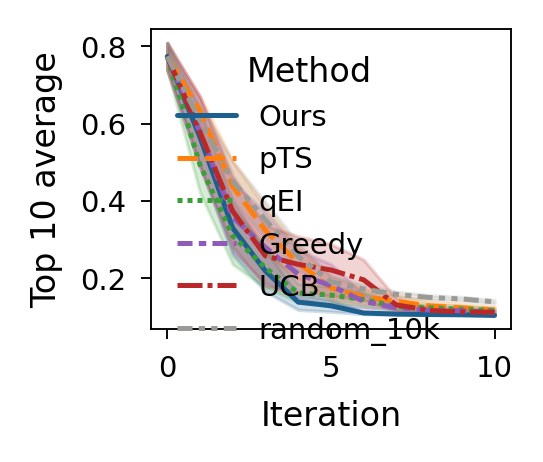

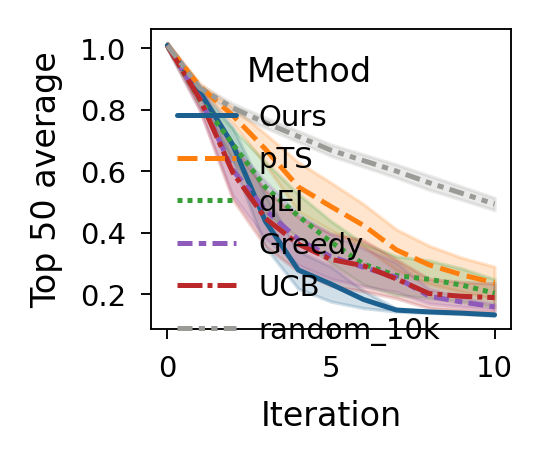

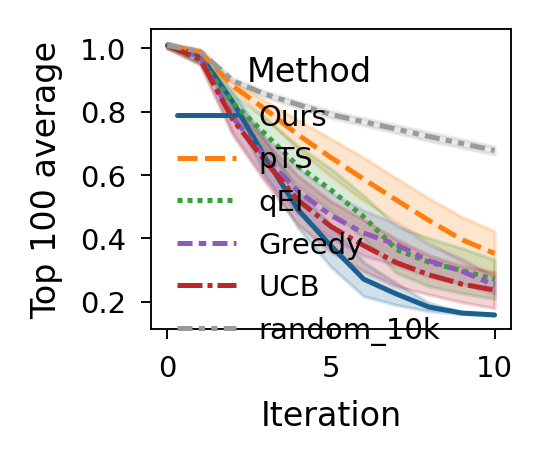

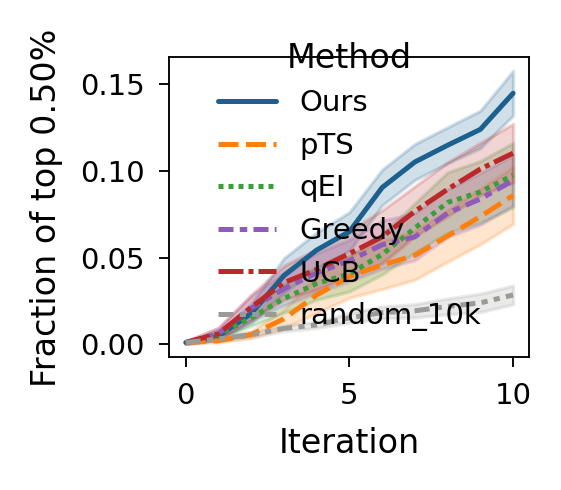

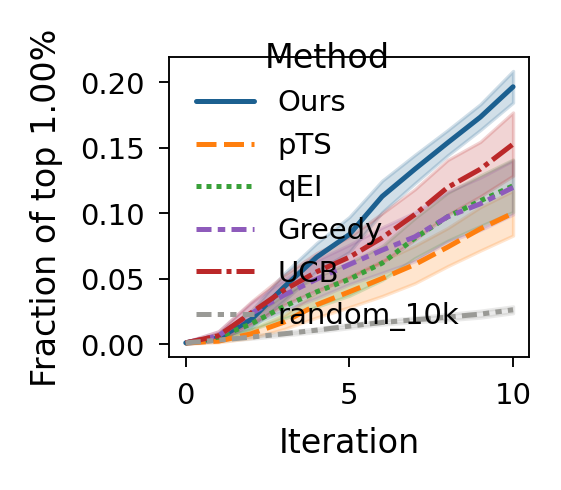

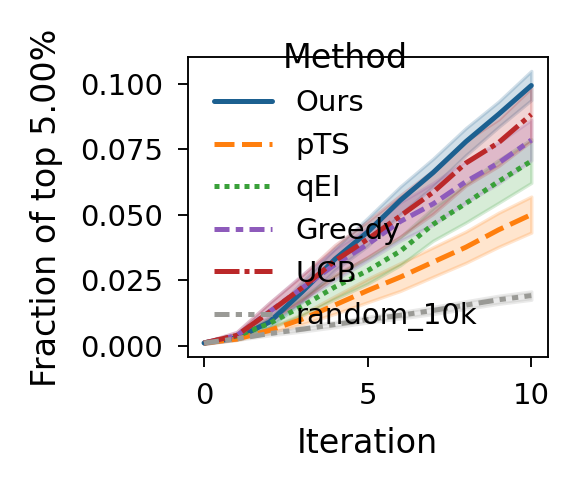

In [11]:
for kk in [10, 50, 100]:
    fig, ax = plt.subplots(1,1)
    sns.lineplot(
        data=data, x='Iteration', y=f'Top {kk} ave', 
        hue='Method', style='Method', 
        ax=ax, palette=plot_utils.method_colors, errorbar=('se',1))
    ax.set_ylabel(f'Top {kk} average')
    plot_utils.set_size(w=1.2, h=1, ax=ax)
    fig.savefig(fig_dir / f'top_{kk}_average.pdf', bbox_inches='tight', transparent=True)

for kk, kkN in zip(k, kN):
    fig, ax = plt.subplots(1,1)
    sns.lineplot(
        data=data, x='Iteration', y=f'Fraction top {100*kk:0.2f}%', 
        hue='Method', style='Method', 
        ax=ax, palette=plot_utils.method_colors, errorbar=("se", 1))
    ax.set_ylabel(f'Fraction of top {100*kk:0.2f}%')
    plot_utils.set_size(w=1.2, h=1, ax=ax)
    fig.savefig(fig_dir / f'fraction_true_top_{kk}.pdf', bbox_inches='tight', transparent=True)

# Visualizing clusters in batches

### Featurizer code 

In [12]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator

def smiles_to_fingerprint_arr(
    smiles_list: list[str],
    radius: int = 3, 
    fpSize: int = 2048,
) -> np.array:
    """ Converts a list of SMILES to a numpy array of fingerprints """

    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=fpSize)
    mols = [Chem.MolFromSmiles(s) for s in smiles_list]
    fps = [mfpgen.GetCountFingerprintAsNumPy(m) for m in mols]
    return np.asarray(fps, dtype=float)

def fp_featurizer(smiles_list): 
    """ Generates a dictionary mapping SMILES in the design space to count Morgan fingerprints """
    fps = smiles_to_fingerprint_arr(smiles_list)
    featurizer = {
        smi: fps[i,:]
        for i, smi in enumerate(smiles_list)
    }
    return featurizer

def tanimoto_similarity(v1: np.array, v2: np.array):

    # Compute dot products and norms
    dot_product = np.dot(v1, v2)
    norm_vec1 = np.dot(v1, v1)
    norm_vec2 = np.dot(v2, v2)
    
    denom = norm_vec1 + norm_vec2 - dot_product

    return dot_product / denom

### Apply to the antibiotics case, which has fewer compounds per batch

In [13]:
result_dir = Path('../results')
fig_dir = Path('antibiotics')

storage = []
for file in result_dir.rglob('wong_antibiotics*.json'): 
    with open(file, 'r') as f: 
        storage.extend(json.load(f))

all_data = pd.read_csv(data_dir / 'wong_antibiotics.csv')
all_smiles = list(all_data['smiles'])
test_data = {smi: score for smi, score in zip(all_smiles, all_data['Mean_50uM'])}

featurizer = fp_featurizer(all_smiles)

[08:37:18] Unusual charge on atom 0 number of radical electrons set to zero


In [14]:
# select random seed and iteration 
rs = 7 
it = 1

methods = ['UCB', 'Ours', 'pTS', 'qEI']
storage_filt = []
for entry in storage: 
    if entry['Method'] in methods: 
        if entry['Iteration']==it and entry['Random seed']==rs: 
            storage_filt.append(entry)

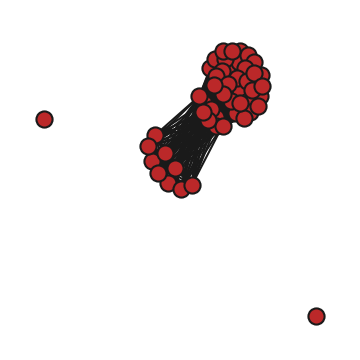

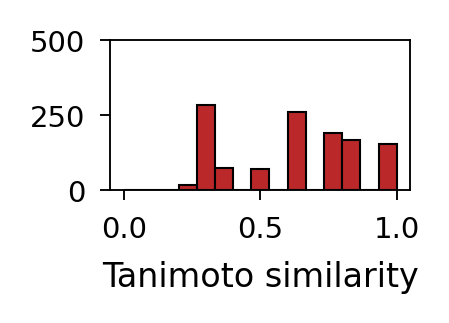

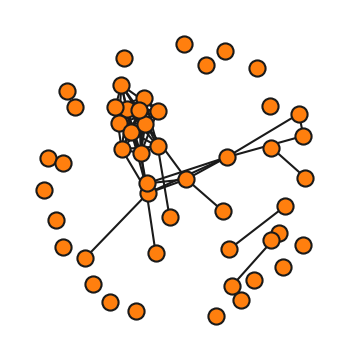

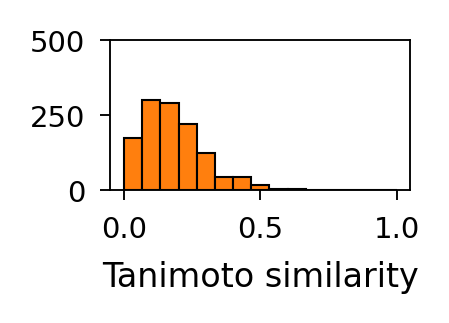

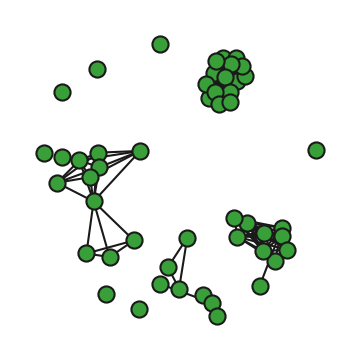

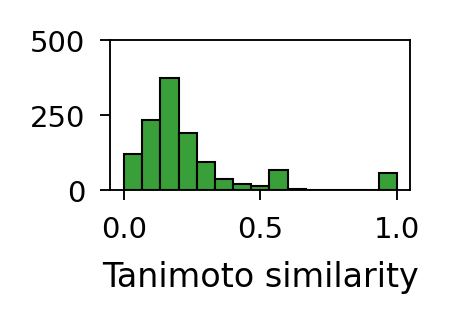

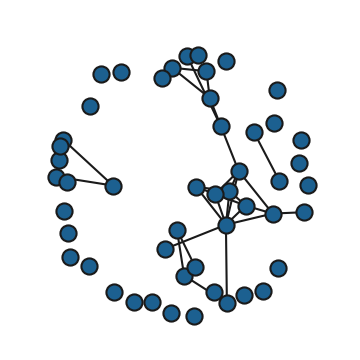

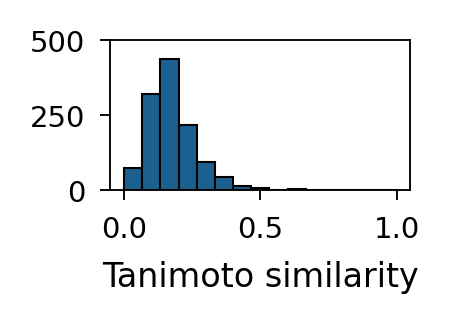

In [15]:
# create nx graphs 
import networkx as nx
tani_min = 0.4

for entry in storage_filt: 
    batch = list(entry['New acquired points'].keys())
    # Create a graph
    G = nx.Graph()

    # Add nodes (sequences) to the graph
    for i, smi in enumerate(batch):
        G.add_node(i, label=str(smi))

    # Add edges based on sequence similarity
    widths = []
    all_sims = []
    for i, smi_1 in enumerate(batch):
        for j, smi_2 in enumerate(batch):
            if i >= j: 
                continue 
            tani_sim = tanimoto_similarity(featurizer[smi_1], featurizer[smi_2])
            all_sims.append(tani_sim)
            if tani_sim > tani_min:
                G.add_edge(i, j, weight=tani_sim)
                widths.append(tani_sim)

    # Visualize the network
    pos = nx.spring_layout(G, seed=0, k=0.5)
    fig, ax = plt.subplots(1,1)
    nx.draw(G, pos, width=0.5,
            node_color=plot_utils.method_colors[entry['Method']], 
            node_size=15, 
            ax=ax, 
            edgecolors='k', linewidths=0.5)
    plot_utils.set_size(w=1, h=1, ax=ax)
    fig.savefig(fig_dir / f'batch_{entry["Method"]}_rs{entry["Random seed"]}_it{entry["Iteration"]}.pdf', bbox_inches='tight', transparent=True)

    # histogram of similarities 
    fig, ax = plt.subplots(1,1)
    ax.hist(all_sims, color=plot_utils.method_colors[entry['Method']], range=[0,1], bins=15, linewidth=0.5, edgecolor='black')
    ax.set_ylim([0,500])
    ax.set_xlabel('Tanimoto similarity')
    plot_utils.set_size(w=1, h=0.5, ax=ax)
    fig.savefig(fig_dir / f'hist_{entry["Method"]}_rs{entry["Random seed"]}_it{entry["Iteration"]}.pdf', bbox_inches='tight', transparent=True)
